# CAB420 Assignment 1A Question 3

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorboard import notebook

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

import scipy.io
import numpy
# numpy.set_printoptions(threshold=numpy.inf)

import os
import datetime
import pydot
import IPython
from IPython.display import SVG

# Question 1
Train a model from scratch, using no data augmentation, on the provided abridged
SVHN training set.

In [2]:
def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):
    
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

In [3]:
def train_and_eval(model, x_train, y_train, x_test, y_test, filename, batch_size, epochs):
    
    checkpoint = ModelCheckpoint(filename, verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
    
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        callbacks=[checkpoint])    
    
    model.load_weights(filename)
    model.save(filename)    
    
    fig = plt.figure(figsize=[30, 10])
    ax = fig.add_subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    ax.legend()
    ax.set_title('Training Performance')

    
    ax = fig.add_subplot(1, 3, 2)
    pred = model.predict(x_train);
    indexes = tf.argmax(pred, axis=1)
    cm = confusion_matrix(y_train, indexes)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)    
    ax.set_title('Training')
    
    ax = fig.add_subplot(1, 3, 3)
    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)
    cm = confusion_matrix(y_test, indexes)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)    
    ax.set_title('Testing')

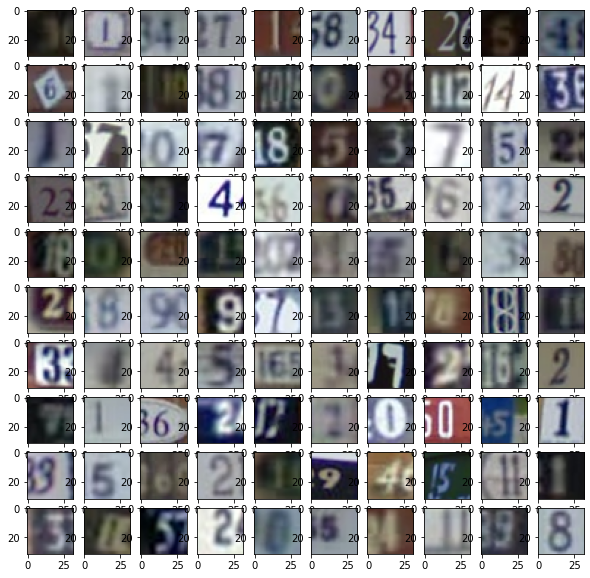

In [4]:
SVHN_train = scipy.io.loadmat(r'C:\Users\under\OneDrive\Documents\CAB420\CAB420_Assessment1A_Data\Data\Q3\q3_train.mat')
SVHN_test = scipy.io.loadmat(r'C:\Users\under\OneDrive\Documents\CAB420\CAB420_Assessment1A_Data\Data\Q3\q3_test.mat')
# print(SVHN_test)
fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(SVHN_train['train_X'][:,:,:,i])

In [5]:
# Change class from [1 - 10] to [0 - 9] as keras takes 0 - 9

for i in range (len(SVHN_train['train_Y'])):
    SVHN_train['train_Y'][i] = SVHN_train['train_Y'][i] - 1
for i in range (len(SVHN_test['test_Y'])):
    SVHN_test['test_Y'][i] = SVHN_test['test_Y'][i] - 1


In [6]:
# Do we need to preserve rbg value(3) in a 4D, or just put 1 in the end
train = numpy.transpose(SVHN_train['train_X'], (3, 0, 1, 2)).reshape(-1, 32, 32, 3)
train_y = SVHN_train['train_Y']
test = numpy.transpose(SVHN_test['test_X'], (3, 0, 1, 2)).reshape(-1, 32, 32, 3)
test_y = SVHN_test['test_Y']

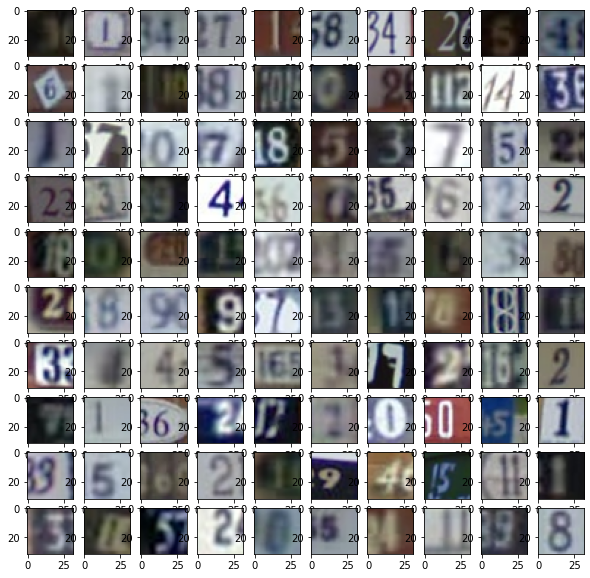

In [7]:
fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(train[i,:,:,:])

Train on 1000 samples, validate on 10000 samples
Epoch 1/20
 896/1000 [=========================>....] - ETA: 0s - loss: 2.6595 - accuracy: 0.1730
Epoch 00001: val_loss improved from inf to 20.40129, saving model to vgg_2stage_FashionMNIST_small.h5
1000/1000 [==============================] - 19s 19ms/sample - loss: 2.6322 - accuracy: 0.1710 - val_loss: 20.4013 - val_accuracy: 0.1168
Epoch 2/20
 896/1000 [=========================>....] - ETA: 0s - loss: 2.0640 - accuracy: 0.2924
Epoch 00002: val_loss improved from 20.40129 to 13.22023, saving model to vgg_2stage_FashionMNIST_small.h5
1000/1000 [==============================] - 15s 15ms/sample - loss: 2.0600 - accuracy: 0.2890 - val_loss: 13.2202 - val_accuracy: 0.0624
Epoch 3/20
 896/1000 [=========================>....] - ETA: 0s - loss: 1.7445 - accuracy: 0.3984
Epoch 00003: val_loss improved from 13.22023 to 2.59621, saving model to vgg_2stage_FashionMNIST_small.h5
1000/1000 [==============================] - 16s 16ms/sample - los

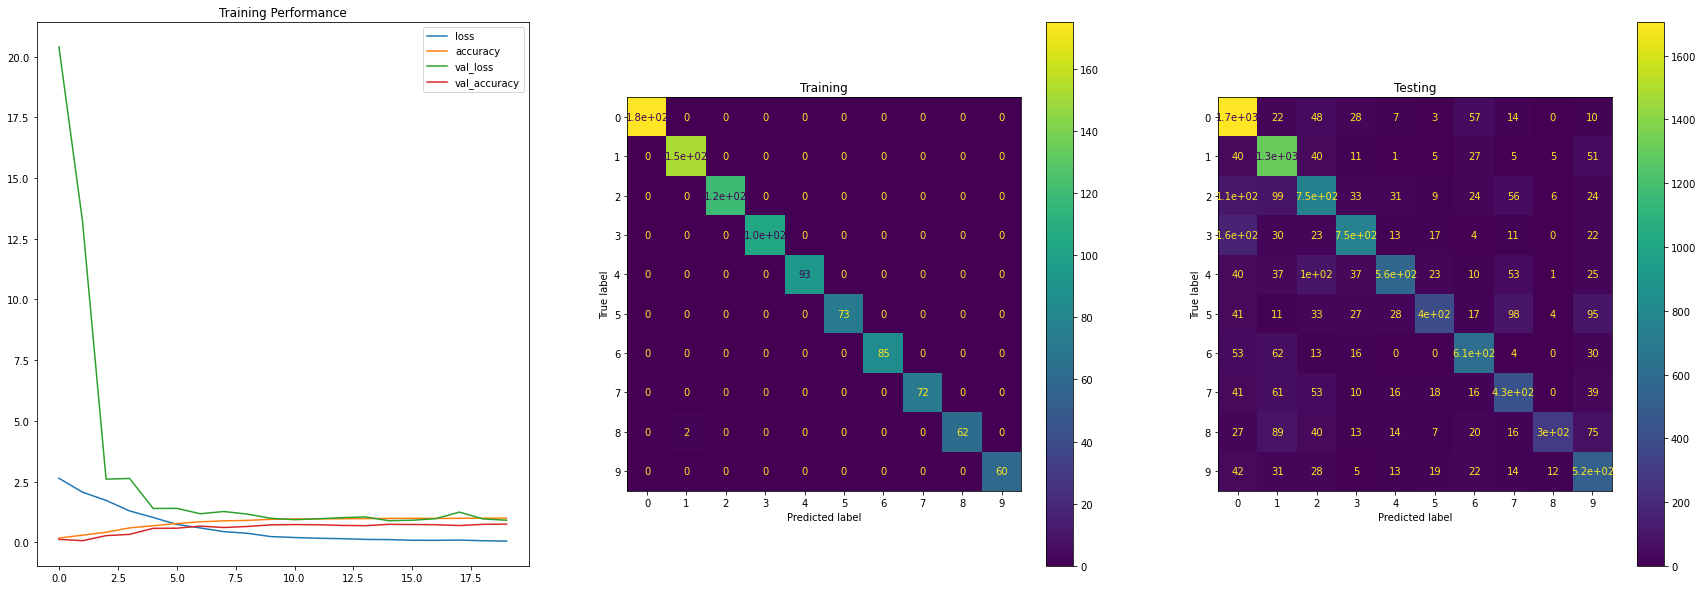

In [8]:
batch_size = 128
num_epochs = 20
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = vgg_net(inputs, [16,32], [1024, 256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])
train_and_eval(model_cnn, train, train_y, test, test_y, 'vgg_2stage_FashionMNIST_small.h5', batch_size, num_epochs)

10000/10000 - 11s - loss: 0.8858 - accuracy: 0.7353
Test loss: 0.8857665238380432
Test accuracy: 0.7353


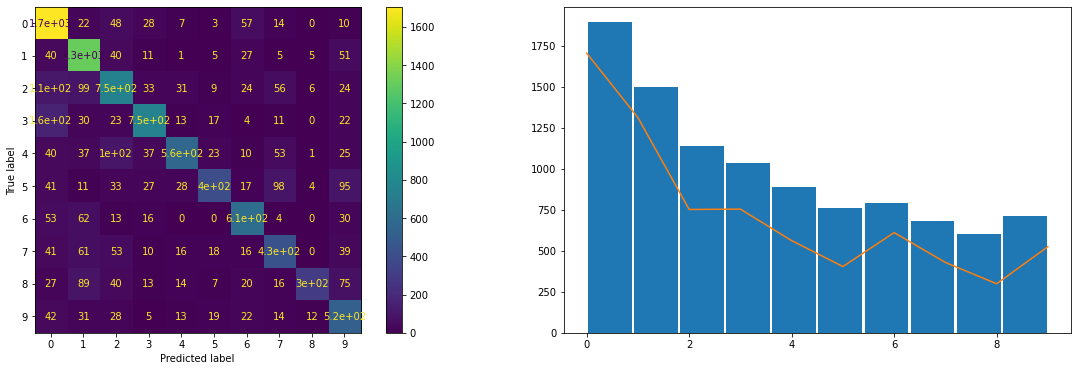

In [9]:
def eval_model(model, x_test, y_test):
    test_scores = model.evaluate(x_test, y_test, verbose=2)
    print('Test loss:', test_scores[0])
    print('Test accuracy:', test_scores[1])

    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)

    cm = confusion_matrix(y_test, indexes)
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 2, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)

    ax = fig.add_subplot(1, 2, 2)
    ax.hist(y_test, bins=len(numpy.diagonal(cm)), rwidth=0.95)
    ax.plot(numpy.diagonal(cm))

eval_model(model_cnn, test, test_y)

# Question 2
Train a model from scratch, using the data augmentation of your choice, on the provided abridged SVHN training set.

In [10]:
datagen = ImageDataGenerator(
                            # rotate between -10, +10 degrees
                            rotation_range=10,
                            # horiziontal shift by +/- 5% of the image width
                            width_shift_range=0.05,
                            # vertical shift by +/- 5% of the image width
                            height_shift_range=0.05,
                            # range for randomly applying a shearing transform
                            shear_range=0.05,
                            # range for zooming
                            zoom_range=0.05,
                            # don't allow horizontal flips of data
                            horizontal_flip=False,
                            # what value to place in new pixels, given the nature of our data (clothes on a black backround)
                            # we'll set this to a constant value of 0
                            fill_mode='constant', cval=0)

In [15]:
batch = datagen.flow(train, train_y, batch_size=1000)

new_train = numpy.append(batch[0][0],train, axis = 0)
new_train_y = numpy.append(batch[0][1],train_y, axis = 0)
batch2 = datagen.flow(train, train_y, batch_size=1000)
new_train = numpy.append(batch2[0][0],new_train, axis = 0)
new_train_y = numpy.append(batch2[0][1],new_train_y, axis = 0)
print(new_train.shape)
print(new_train_y.shape)

# fig = plt.figure(figsize=[10, 10])
# for i in range(100):
#     ax = fig.add_subplot(10, 10, i + 1)
#     ax.imshow((batch[0][0][i,:,:,:]).astype('uint8'))

(3000, 32, 32, 3)
(3000, 1)


Train on 3000 samples, validate on 10000 samples
Epoch 1/20
2944/3000 [============================>.] - ETA: 0s - loss: 2.2796 - accuracy: 0.2415
Epoch 00001: val_loss improved from inf to 2.20960, saving model to vgg_2stage_FashionMNIST_small_1.h5
3000/3000 [==============================] - 20s 7ms/sample - loss: 2.2705 - accuracy: 0.2437 - val_loss: 2.2096 - val_accuracy: 0.3075
Epoch 2/20
2944/3000 [============================>.] - ETA: 0s - loss: 1.3269 - accuracy: 0.5577
Epoch 00002: val_loss improved from 2.20960 to 1.25757, saving model to vgg_2stage_FashionMNIST_small_1.h5
3000/3000 [==============================] - 20s 7ms/sample - loss: 1.3202 - accuracy: 0.5600 - val_loss: 1.2576 - val_accuracy: 0.5982
Epoch 3/20
2944/3000 [============================>.] - ETA: 0s - loss: 0.7782 - accuracy: 0.7551
Epoch 00003: val_loss improved from 1.25757 to 0.93916, saving model to vgg_2stage_FashionMNIST_small_1.h5
3000/3000 [==============================] - 21s 7ms/sample - loss: 

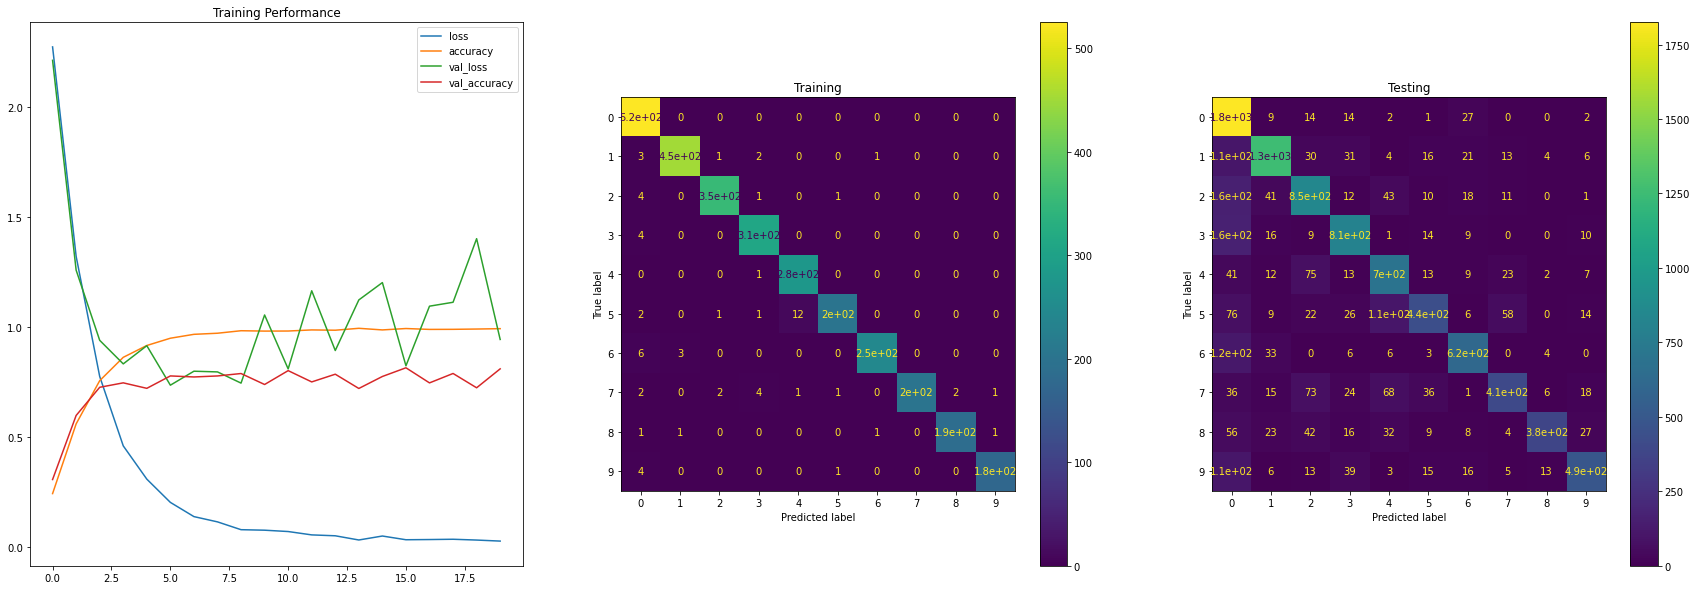

In [16]:
batch_size = 128
num_epochs = 20
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = vgg_net(inputs, [16,32], [1024, 256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])
train_and_eval(model_cnn, new_train, new_train_y, test, test_y, 'vgg_2stage_FashionMNIST_small_1.h5', batch_size, num_epochs)

10000/10000 - 10s - loss: 0.7356 - accuracy: 0.7776
Test loss: 0.7355738317489624
Test accuracy: 0.7776


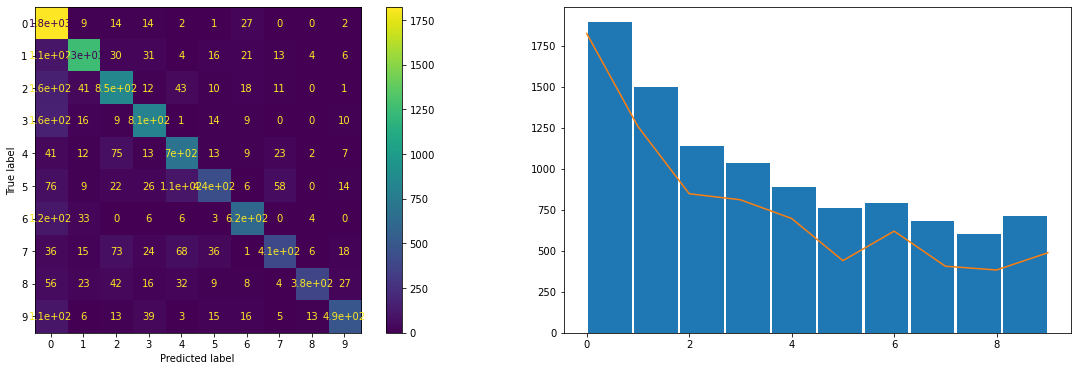

In [17]:
eval_model(model_cnn, test, test_y)